# Chapter 9: Unsupervised Learning Techniques

### Ensure GPU Env is working correctly

In [1]:
import tensorflow as tf
from tensorflow import keras
%env OMP_NUM_THREADS=8

env: OMP_NUM_THREADS=8


In [2]:
print("Num of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs Available:  1


In [3]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
sys.version

'3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]'

## Clustering

### K-Means Clustering

In [4]:
# Create Blob Dataset
from sklearn.datasets import make_blobs

In [5]:
import numpy as np
# 5 Clusters
blob_centers = np.array(
    [[ 0.1,  2.3],
     [-1.5 ,  3.0],
     [-2.8,  1.3],
     [-1.8,  1.8],
     [-2.8,  3.8]])
blob_std = np.array([0.4, 0.2, 0.1, 0.4, 0.2])

In [6]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std)

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

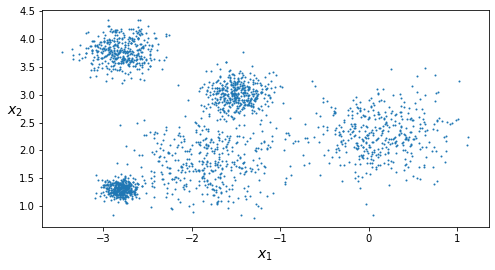

In [8]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [9]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [10]:
y_pred

array([3, 3, 3, ..., 2, 0, 3])

In [11]:
y_pred is kmeans.labels_

True

In [12]:
# 5 centroids (cluster centers) estimated
kmeans.cluster_centers_

array([[ 0.12671841,  2.28172295],
       [-2.80094963,  3.78196093],
       [-1.7714539 ,  1.77401958],
       [-2.77024145,  1.31928791],
       [-1.48681186,  2.99138479]])

### Visualization of Clusters Using Decision Boundaries

In [13]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

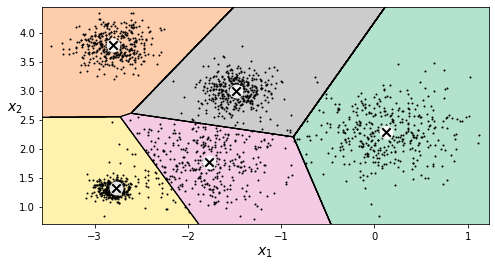

In [14]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

### Hard Clustering vs Soft Clustering

Picking our K-value =5 and assigning each instance to a single cluster is known as *hard clustering* but we could also measure the distance of the instance to each cluster center (centroid) with its euclidian distance and that is a form of *soft clustering*

This can be achieved using the transform method, then can verify with the euclidean distance equation:

In [15]:
kmeans.transform(X)

array([[2.70114039, 2.29637986, 0.73908511, 0.36280901, 1.77297494],
       [3.08727127, 2.34438982, 1.12302131, 0.13919634, 2.06214418],
       [2.94803846, 2.63765899, 1.03299987, 0.24110872, 2.14791699],
       ...,
       [2.1253205 , 2.68787196, 0.47040678, 1.01013744, 1.70964199],
       [0.222136  , 3.07796685, 1.86074147, 2.95679385, 1.55645392],
       [3.03319717, 2.4013443 , 1.07280047, 0.0615367 , 2.05899506]])

This is interpreted as distance from each cluster. So the first instance is 0.27 away from the first centroid, 2.34 from the second, 1.68 from the third and so on...

In [16]:
np.linalg.norm(np.tile(X, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.70114039, 2.29637986, 0.73908511, 0.36280901, 1.77297494],
       [3.08727127, 2.34438982, 1.12302131, 0.13919634, 2.06214418],
       [2.94803846, 2.63765899, 1.03299987, 0.24110872, 2.14791699],
       ...,
       [2.1253205 , 2.68787196, 0.47040678, 1.01013744, 1.70964199],
       [0.222136  , 3.07796685, 1.86074147, 2.95679385, 1.55645392],
       [3.03319717, 2.4013443 , 1.07280047, 0.0615367 , 2.05899506]])

## The K-Means Algorithm + Visualization

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:

- First initialize ***k*** centroids randomly: ***k*** distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
- Repeat until convergence (i.e., until the centroids stop moving):
    - Assign each instance to the closest centroid.
    - Update the centroids to be the mean of the instances that are assigned to them.
    
This video on youtube also gives a very clear explanation on how it works (Recommended): https://www.youtube.com/watch?v=_aWzGGNrcic

In [17]:
# Iteration setup for our centroids move around with different iteration counts
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=5, n_clusters=5, n_init=1)

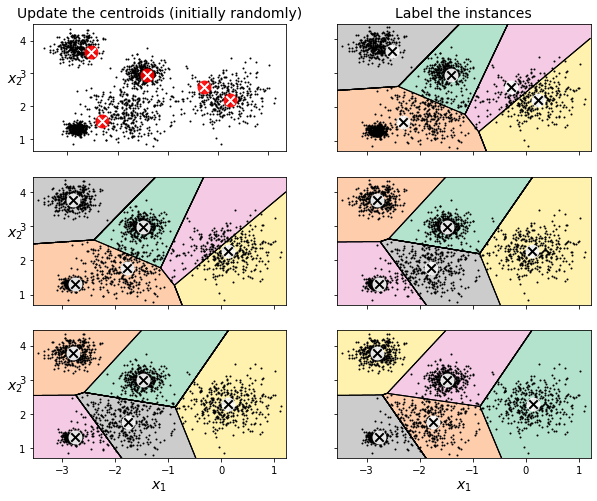

In [18]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

Because this is an unsupervised algorithm, with different iterations or random states, we can actually get completely different final results. Look at the difference shown below with a new random state:

In [19]:
kmeans_new_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=8)
kmeans_new_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=8)
kmeans_new_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=5, random_state=8)
kmeans_new_iter1.fit(X)
kmeans_new_iter2.fit(X)
kmeans_new_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=5, n_clusters=5, n_init=1,
       random_state=8)

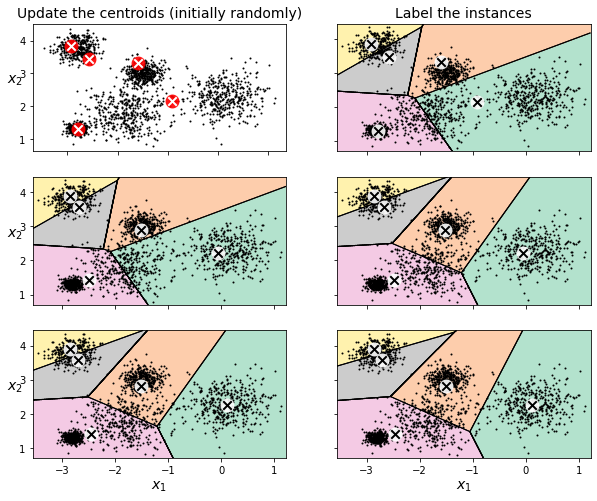

In [20]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_new_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_new_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_new_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_new_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_new_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_new_iter2, X, show_centroids=False)
plot_centroids(kmeans_new_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_new_iter3, X, show_ylabels=False)

plt.show()

Here's another example with just 2 solutions and 1 iteration:

In [21]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

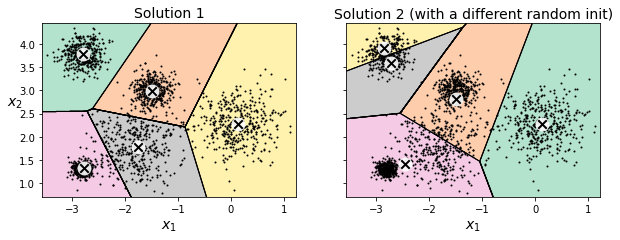

In [22]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=10)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=8)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

### Centroid Initialization Methods

If you ran previous clustering algorithm, you can plot approximately where the centroids should be as an initialization parameter calling the KMeans method shown below:

In [23]:
good_init = np.array([[-3, 3.5], [-3, 1], [-1.75, 1.5], [-1.5, 3], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3.  ,  3.5 ],
       [-3.  ,  1.  ],
       [-1.75,  1.5 ],
       [-1.5 ,  3.  ],
       [ 0.  ,  2.  ]]),
       n_clusters=5, n_init=1)

In [24]:
kmeans.inertia_

302.90418485075435

In [25]:
kmeans.score(X)

-302.90418485075435

## Mini-Batch K-Means Algorithm

In [26]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [27]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [28]:
minibatch_kmeans.inertia_

305.20415517904155

If the dataset doesn't fit in memory the simplest option is to use the memmap class:

In [29]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"])

In [31]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [32]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10)

In [33]:
# if dataset is too large, use below function to load next batch from the disk
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [34]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500 
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
    
    if (best_kmeans is None or minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [35]:
best_kmeans.score(X)

-303.07180264123843

Speed difference for KMeans vs MiniBatchKMeans:

In [36]:
%timeit KMeans(n_clusters=5).fit(X)

34.8 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

24.1 ms ± 882 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Visualization of Intertia Ratio and Training Time Ratio for Mini-Batch K-Means and K-Means

In [38]:
from timeit import timeit

In [39]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

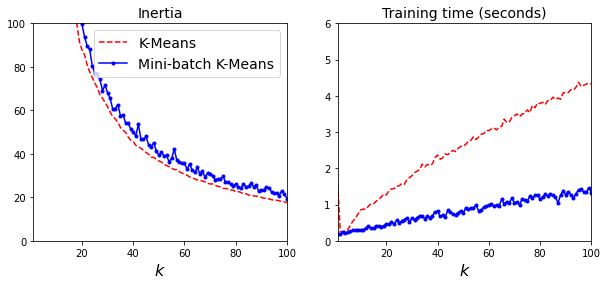

In [40]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

## Trying to Find the Optimal Number of Clusters in KMeans

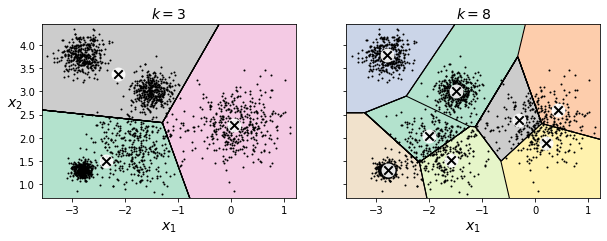

In [41]:
kmeans_k3 = KMeans(n_clusters=3)
kmeans_k8 = KMeans(n_clusters=8)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [42]:
# validate intertias for models
print(kmeans_k3.inertia_)
print(kmeans_k8.inertia_)

1000.0217411730516
198.11216673833803


The inertia will continue to drop as we increase k, so we need to plot inertia as a curve and use what is known as the ***elbow method** for selecting the ideal k value

## Visualization of Elbow Method for K Value

In [43]:
kmeans_per_k = [KMeans(n_clusters=k).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
print(kmeans_per_k)

[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9)]


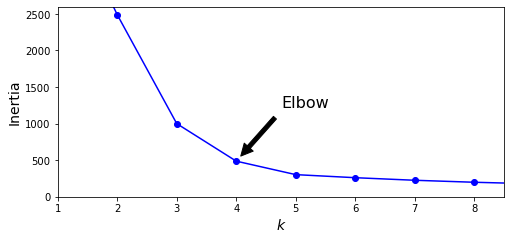

In [54]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 2600])
plt.show()

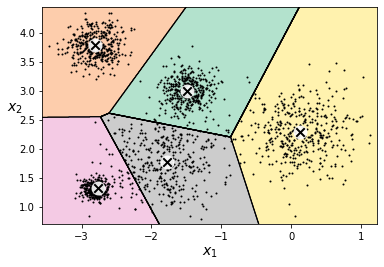

In [55]:
plot_decision_boundaries(kmeans_per_k[4], X) #array is 0,1,2,3,4
plt.show()

## Silhouette Score

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's look at that now:

In [56]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.6489938163822155

In [57]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

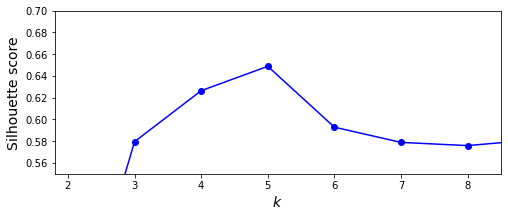

In [58]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

This graph shows us what we already know about 5, but it also shows k=4 is also a good fit as well given our dataset

## Problems/Limits of K-Means

In [59]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

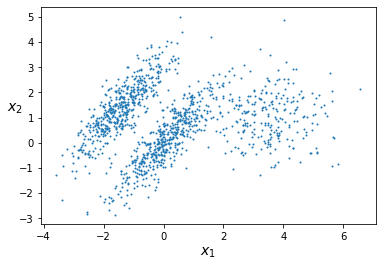

In [60]:
plot_clusters(X)

In [61]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

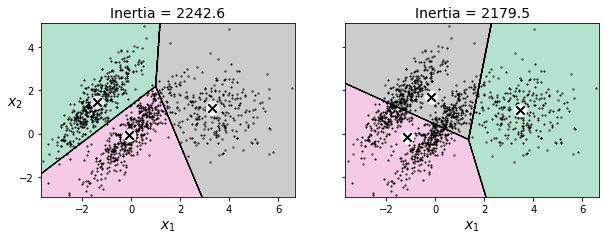

In [62]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

As you can see, neither of these choices produce good models so it is important to realize that different clustering algorithms may perform better depending on the data you are modeling.

## Clustering for Image Segmentation

In [63]:
# Download the ladybug image
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x1ff04ed0ba8>)

In [64]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [65]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [66]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

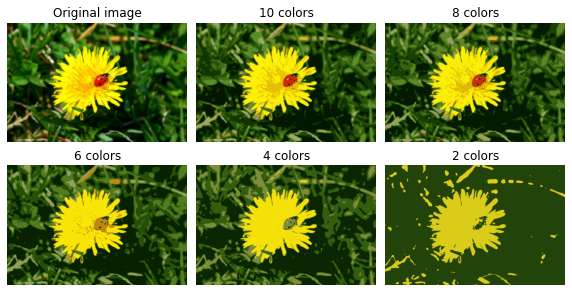

In [67]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

## Using Clustering for Preprocessing

In [68]:
# Load digits dataset
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [69]:
#Train-Test-Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

Now fit logistic regression and evaluate on test data:

In [70]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr')

In [71]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.96

Let's use this score as our baseline and create a pipeline using KMeans as a preprocessing step (50 clusters and replace images with distances to 50 clusters) to see if we can get better results:

In [72]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr'))])

In [73]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.98

In [74]:
# Drop in error rate
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.5

Now because we chose ***K***, lets use gridsearch to find better parameters for our model

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(1,151))
grid_clf = GridSearchCV(pipeline, param_grid, cv=5, verbose=3)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END ..............kmeans__n_clusters=1;, score=0.200 total time=   0.1s
[CV 2/5] END ..............kmeans__n_clusters=1;, score=0.181 total time=   0.1s
[CV 3/5] END ..............kmeans__n_clusters=1;, score=0.197 total time=   0.1s
[CV 4/5] END ..............kmeans__n_clusters=1;, score=0.208 total time=   0.1s
[CV 5/5] END ..............kmeans__n_clusters=1;, score=0.204 total time=   0.1s
[CV 1/5] END ..............kmeans__n_clusters=2;, score=0.385 total time=   0.0s
[CV 2/5] END ..............kmeans__n_clusters=2;, score=0.426 total time=   0.0s
[CV 3/5] END ..............kmeans__n_clusters=2;, score=0.439 total time=   0.0s
[CV 4/5] END ..............kmeans__n_clusters=2;, score=0.468 total time=   0.0s
[CV 5/5] END ..............kmeans__n_clusters=2;, score=0.383 total time=   0.0s
[CV 1/5] END ..............kmeans__n_clusters=3;, score=0.596 total time=   0.0s
[CV 2/5] END ..............kmeans__n_clusters=

[CV 2/5] END .............kmeans__n_clusters=21;, score=0.959 total time=   1.5s
[CV 3/5] END .............kmeans__n_clusters=21;, score=0.959 total time=   1.3s
[CV 4/5] END .............kmeans__n_clusters=21;, score=0.952 total time=   1.4s
[CV 5/5] END .............kmeans__n_clusters=21;, score=0.963 total time=   1.4s
[CV 1/5] END .............kmeans__n_clusters=22;, score=0.963 total time=   1.4s
[CV 2/5] END .............kmeans__n_clusters=22;, score=0.956 total time=   1.4s
[CV 3/5] END .............kmeans__n_clusters=22;, score=0.959 total time=   1.5s
[CV 4/5] END .............kmeans__n_clusters=22;, score=0.955 total time=   1.5s
[CV 5/5] END .............kmeans__n_clusters=22;, score=0.948 total time=   1.4s
[CV 1/5] END .............kmeans__n_clusters=23;, score=0.967 total time=   1.5s
[CV 2/5] END .............kmeans__n_clusters=23;, score=0.948 total time=   1.5s
[CV 3/5] END .............kmeans__n_clusters=23;, score=0.963 total time=   1.5s
[CV 4/5] END .............km

[CV 4/5] END .............kmeans__n_clusters=41;, score=0.970 total time=   2.2s
[CV 5/5] END .............kmeans__n_clusters=41;, score=0.959 total time=   2.2s
[CV 1/5] END .............kmeans__n_clusters=42;, score=0.978 total time=   2.0s
[CV 2/5] END .............kmeans__n_clusters=42;, score=0.967 total time=   2.0s
[CV 3/5] END .............kmeans__n_clusters=42;, score=0.978 total time=   2.6s
[CV 4/5] END .............kmeans__n_clusters=42;, score=0.970 total time=   2.3s
[CV 5/5] END .............kmeans__n_clusters=42;, score=0.955 total time=   2.4s
[CV 1/5] END .............kmeans__n_clusters=43;, score=0.989 total time=   2.2s
[CV 2/5] END .............kmeans__n_clusters=43;, score=0.959 total time=   2.2s
[CV 3/5] END .............kmeans__n_clusters=43;, score=0.970 total time=   2.4s
[CV 4/5] END .............kmeans__n_clusters=43;, score=0.970 total time=   2.3s
[CV 5/5] END .............kmeans__n_clusters=43;, score=0.967 total time=   1.9s
[CV 1/5] END .............km

[CV 1/5] END .............kmeans__n_clusters=62;, score=0.989 total time=   2.7s
[CV 2/5] END .............kmeans__n_clusters=62;, score=0.963 total time=   2.3s
[CV 3/5] END .............kmeans__n_clusters=62;, score=0.974 total time=   2.9s
[CV 4/5] END .............kmeans__n_clusters=62;, score=0.970 total time=   2.5s
[CV 5/5] END .............kmeans__n_clusters=62;, score=0.967 total time=   2.5s
[CV 1/5] END .............kmeans__n_clusters=63;, score=0.993 total time=   2.3s
[CV 2/5] END .............kmeans__n_clusters=63;, score=0.959 total time=   2.3s
[CV 3/5] END .............kmeans__n_clusters=63;, score=0.974 total time=   2.9s
[CV 4/5] END .............kmeans__n_clusters=63;, score=0.967 total time=   2.8s
[CV 5/5] END .............kmeans__n_clusters=63;, score=0.967 total time=   2.4s
[CV 1/5] END .............kmeans__n_clusters=64;, score=0.989 total time=   2.6s
[CV 2/5] END .............kmeans__n_clusters=64;, score=0.967 total time=   2.4s
[CV 3/5] END .............km

[CV 3/5] END .............kmeans__n_clusters=82;, score=0.978 total time=   2.7s
[CV 4/5] END .............kmeans__n_clusters=82;, score=0.967 total time=   2.6s
[CV 5/5] END .............kmeans__n_clusters=82;, score=0.970 total time=   2.6s
[CV 1/5] END .............kmeans__n_clusters=83;, score=0.989 total time=   2.6s
[CV 2/5] END .............kmeans__n_clusters=83;, score=0.963 total time=   2.7s
[CV 3/5] END .............kmeans__n_clusters=83;, score=0.978 total time=   2.9s
[CV 4/5] END .............kmeans__n_clusters=83;, score=0.967 total time=   2.7s
[CV 5/5] END .............kmeans__n_clusters=83;, score=0.967 total time=   2.6s
[CV 1/5] END .............kmeans__n_clusters=84;, score=0.993 total time=   2.4s
[CV 2/5] END .............kmeans__n_clusters=84;, score=0.963 total time=   2.7s
[CV 3/5] END .............kmeans__n_clusters=84;, score=0.978 total time=   2.5s
[CV 4/5] END .............kmeans__n_clusters=84;, score=0.967 total time=   2.7s
[CV 5/5] END .............km

[CV 5/5] END ............kmeans__n_clusters=102;, score=0.970 total time=   2.6s
[CV 1/5] END ............kmeans__n_clusters=103;, score=0.989 total time=   3.3s
[CV 2/5] END ............kmeans__n_clusters=103;, score=0.959 total time=   2.6s
[CV 3/5] END ............kmeans__n_clusters=103;, score=0.970 total time=   2.8s
[CV 4/5] END ............kmeans__n_clusters=103;, score=0.967 total time=   2.9s
[CV 5/5] END ............kmeans__n_clusters=103;, score=0.967 total time=   3.0s
[CV 1/5] END ............kmeans__n_clusters=104;, score=0.993 total time=   2.7s
[CV 2/5] END ............kmeans__n_clusters=104;, score=0.967 total time=   2.8s
[CV 3/5] END ............kmeans__n_clusters=104;, score=0.978 total time=   3.0s
[CV 4/5] END ............kmeans__n_clusters=104;, score=0.967 total time=   2.9s
[CV 5/5] END ............kmeans__n_clusters=104;, score=0.970 total time=   3.0s
[CV 1/5] END ............kmeans__n_clusters=105;, score=0.993 total time=   2.7s
[CV 2/5] END ............kme

[CV 2/5] END ............kmeans__n_clusters=123;, score=0.959 total time=   2.8s
[CV 3/5] END ............kmeans__n_clusters=123;, score=0.978 total time=   3.2s
[CV 4/5] END ............kmeans__n_clusters=123;, score=0.970 total time=   2.7s
[CV 5/5] END ............kmeans__n_clusters=123;, score=0.978 total time=   2.8s
[CV 1/5] END ............kmeans__n_clusters=124;, score=0.989 total time=   2.6s
[CV 2/5] END ............kmeans__n_clusters=124;, score=0.963 total time=   2.8s
[CV 3/5] END ............kmeans__n_clusters=124;, score=0.970 total time=   2.9s
[CV 4/5] END ............kmeans__n_clusters=124;, score=0.967 total time=   2.8s
[CV 5/5] END ............kmeans__n_clusters=124;, score=0.974 total time=   2.9s
[CV 1/5] END ............kmeans__n_clusters=125;, score=0.989 total time=   3.0s
[CV 2/5] END ............kmeans__n_clusters=125;, score=0.959 total time=   3.0s
[CV 3/5] END ............kmeans__n_clusters=125;, score=0.978 total time=   2.8s
[CV 4/5] END ............kme

[CV 4/5] END ............kmeans__n_clusters=143;, score=0.967 total time=   2.8s
[CV 5/5] END ............kmeans__n_clusters=143;, score=0.978 total time=   3.0s
[CV 1/5] END ............kmeans__n_clusters=144;, score=0.985 total time=   3.2s
[CV 2/5] END ............kmeans__n_clusters=144;, score=0.963 total time=   3.1s
[CV 3/5] END ............kmeans__n_clusters=144;, score=0.974 total time=   3.2s
[CV 4/5] END ............kmeans__n_clusters=144;, score=0.970 total time=   2.7s
[CV 5/5] END ............kmeans__n_clusters=144;, score=0.967 total time=   2.6s
[CV 1/5] END ............kmeans__n_clusters=145;, score=0.989 total time=   2.6s
[CV 2/5] END ............kmeans__n_clusters=145;, score=0.963 total time=   2.8s
[CV 3/5] END ............kmeans__n_clusters=145;, score=0.978 total time=   2.9s
[CV 4/5] END ............kmeans__n_clusters=145;, score=0.967 total time=   3.2s
[CV 5/5] END ............kmeans__n_clusters=145;, score=0.970 total time=   3.0s
[CV 1/5] END ............kme

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr'))]),
             param_grid={'kmeans__n_clusters': range(1, 151)}, verbose=3)

In [76]:
grid_clf.best_params_

{'kmeans__n_clusters': 70}

In [77]:
grid_clf.score(X_test, y_test)

0.9822222222222222

From here we are able to improve our performance a little bit more than before.

## Using Clustering for Semi-Supervised Learning

In [160]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs")
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.7844444444444445

Using the labelled 50 instances in the above snipped of code, we see the performance on the test set to be **"0.82"**. What we could try next is to cluster the training set into 50 clusters, then find the image closest to the centroid. So these representative images will be clustered and we will try and classfy the numbers this way:

In [161]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

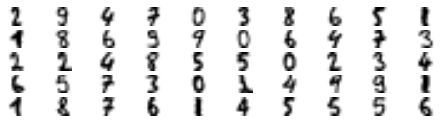

In [162]:
# Plot images of the numbers
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [163]:
y_train[representative_digit_idx]

array([2, 9, 4, 7, 0, 3, 8, 6, 5, 1, 1, 8, 6, 9, 9, 0, 6, 4, 7, 3, 2, 2,
       4, 8, 5, 5, 0, 2, 3, 4, 6, 5, 7, 3, 0, 1, 4, 9, 9, 1, 1, 8, 7, 6,
       1, 4, 5, 5, 5, 6])

In [164]:
## Create array of labelled y_training variable as seperate variable
y_representative_digits = np.array([2, 9, 4, 7, 0, 3, 8, 6, 5, 1, 1, 8, 6, 9, 9, 0, 6, 4, 7, 3, 2, 2,
       4, 8, 5, 5, 0, 2, 3, 4, 6, 5, 7, 3, 0, 1, 4, 9, 9, 1, 1, 8, 7, 6,
       1, 4, 5, 5, 5, 6])

In [165]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9

Great accuracy boost! From here, we can go one step further and progagate the labels to the other instances in the same cluster. This is known as *Label Propagation* and it can be seen below:

In [166]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
    print(y_train_propagated[kmeans.labels_==i])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Now you can see all the 50 clusters in action and what digits they look to represent based on the cluster categorization. 

In [167]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr')

In [168]:
log_reg.score(X_test, y_test)

0.9177777777777778

Another accuracy boost. Great! One final thing we could do is propagate the labels to 50% of the instances that are closest to the cluster centroids. We would do this to better classify the instances located close to the cluster boundaries where they could belong to another cluster and may be mislabeled.

In [169]:
percentile_closest = 50

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [170]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [171]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr')

In [172]:
log_reg.score(X_test, y_test)

0.9066666666666666

If we chose a lower number such as 25%, we would probably see an even higher score for our logistic regression. We will keep 50% for this exercise.

We were able to get such a great performance due to the propagated labels being VERY good for our model. Their accuracy ~~ 99% because of how we classified them and visualized the digits as well

In [173]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9854651162790697

## DBSCAN

In [174]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [175]:
dbscan.labels_[:10]

array([ 0,  7,  4,  1,  2,  3,  4,  3, -1,  3], dtype=int64)

In [176]:
len(dbscan.core_sample_indices_)

789

In [177]:
dbscan.core_sample_indices_[:10]

array([ 0,  3,  4,  5,  6,  7,  9, 10, 12, 13], dtype=int64)

In [178]:
dbscan.components_[:3]

array([[0.56516528, 0.81560217],
       [1.94708742, 0.25822076],
       [0.73623486, 0.72129033]])

In [179]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [180]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [181]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

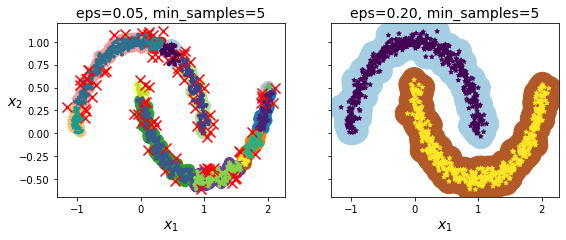

In [182]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [183]:
dbscan = dbscan2
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [184]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([0, 1, 0, 1], dtype=int64)

In [185]:
knn.predict_proba(X_new)

array([[0.88, 0.12],
       [0.  , 1.  ],
       [0.82, 0.18],
       [0.  , 1.  ]])

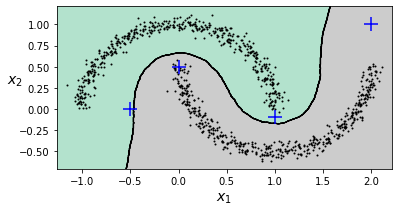

In [186]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [187]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  1,  0, -1], dtype=int64)

## Other Clustering Algorithms 

### Agglomerative Clustering

In [188]:
from sklearn.cluster import AgglomerativeClustering
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [189]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [190]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [191]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

### Spectral Clustering

In [192]:
from sklearn.cluster import SpectralClustering
X, y = make_moons(n_samples=1000, noise=0.05)
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [193]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [194]:
np.percentile(sc1.affinity_matrix_, 95)

0.04018538429099004

In [195]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

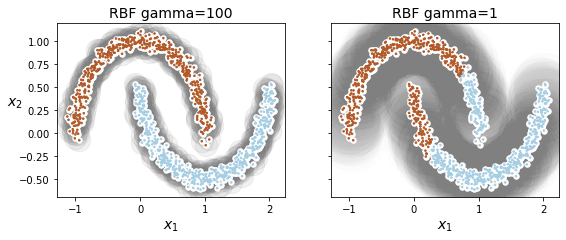

In [196]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

## Gaussian Mixtures

In [197]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)))
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [198]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [199]:
gm.weights_

array([0.2      , 0.3989716, 0.4010284])

In [200]:
gm.means_

array([[ -2.95797005, -13.46527623],
       [ -1.46292356,   1.35435547],
       [ -0.03498234,  -0.02518666]])

In [201]:
gm.covariances_

array([[[1.03679163, 0.00341417],
        [0.00341417, 0.96959679]],

       [[0.59541148, 0.72526168],
        [0.72526168, 1.24937662]],

       [[0.66201472, 0.79063182],
        [0.79063182, 1.29944555]]])

In [202]:
gm.converged_ # Algorithm Converged?

True

In [203]:
gm.n_iter_ # How many iterations to converge

3

In [204]:
gm.predict(X)

array([2, 1, 1, ..., 0, 0, 0], dtype=int64)

In [205]:
gm.predict_proba(X)

array([[1.14881555e-046, 1.90217969e-008, 9.99999981e-001],
       [1.35342595e-066, 9.99999690e-001, 3.10320796e-007],
       [9.92721998e-037, 9.99917689e-001, 8.23108317e-005],
       ...,
       [1.00000000e+000, 2.66486015e-126, 9.10758726e-083],
       [1.00000000e+000, 4.35003518e-163, 3.49576246e-111],
       [1.00000000e+000, 1.70829987e-128, 1.07956462e-084]])

In [206]:
X_new, y_new = gm.sample(6)
X_new

array([[ -2.84277875, -11.36883614],
       [ -1.87453268,   1.54904955],
       [ -1.1510453 ,   1.95847383],
       [ -2.43048963,  -0.38179881],
       [ -1.51139081,   0.92043053],
       [  1.35098089,   1.06206399]])

In [207]:
y_new

array([0, 1, 1, 1, 1, 2])

In [208]:
gm.score_samples(X)

array([-2.25888157, -3.95610351, -3.90314858, ..., -4.01390895,
       -6.11199302, -4.24103365])

In [209]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.8000441207227738

In [210]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

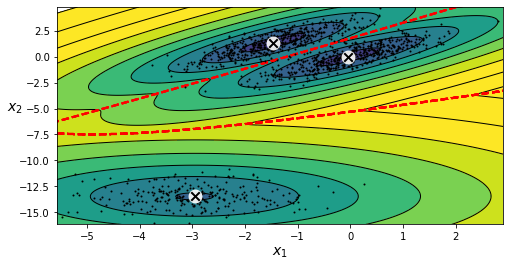

In [211]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

There are different convariance types that can be used for Gaussian Mixtures, including the following with their descriptions:

- "full" (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
- "tied": all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance -- matrix).
- "spherical": all clusters must be spherical, but they can have different diameters (i.e., different variances).
- "diag": clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [212]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full")
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied")
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical")
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag")
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10)

In [213]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

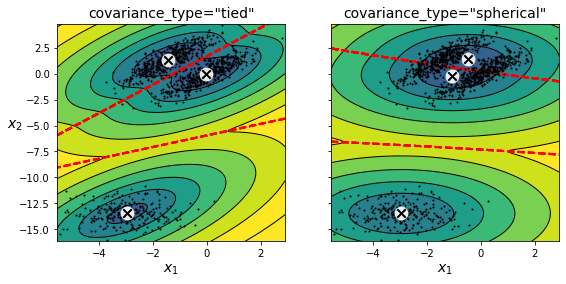

In [214]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

plt.show()

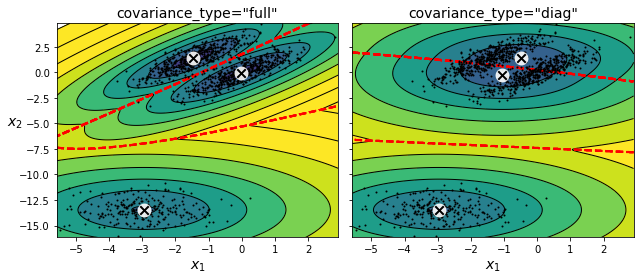

In [215]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Anomaly Detection Using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [216]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

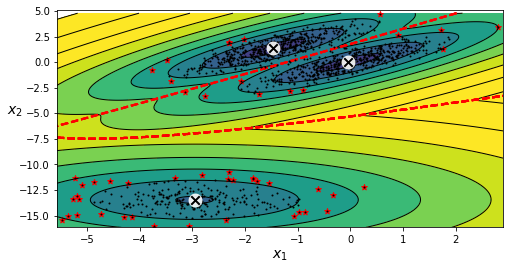

In [217]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

## Selecting the Number of Clusters

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [218]:
gm.bic(X)

8349.248270162834

In [219]:
gm.aic(X)

8262.022990047797

We can compute the BIC manually as well:

In [220]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [221]:
bic, aic

(8349.248270162834, 8262.022990047797)

In [222]:
n_params

17

There is one weight per cluster but the sum needs to equal one so we have one degree of freedom less, hence the -1

Now we can train the Gaussian Mixture models on different values of K and view our "Elbow Model" From earlier

In [223]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [224]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

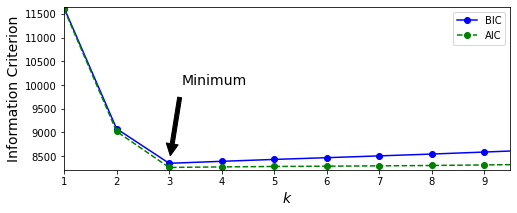

In [226]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Best combination fo values for number of clusters and covariance_type hyperparameter:

In [227]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [228]:
best_k

3

In [229]:
best_covariance_type

'full'

## Bayesian Gaussian Mixture Models

Rather than manually searching for the optimal number of clusters, it is possible to use instead the BayesianGaussianMixture class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [230]:
from sklearn.mixture import BayesianGaussianMixture

In [231]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10)

In [232]:
np.round(bgm.weights_, 2)

array([0.4, 0.2, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

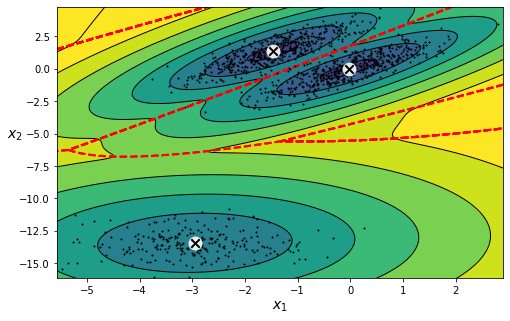

In [233]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [234]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10,
                        weight_concentration_prior=10000)

In [235]:
np.round(bgm_low.weights_, 2)

array([0.57, 0.01, 0.41, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [236]:
np.round(bgm_high.weights_, 2)

array([0.51, 0.01, 0.01, 0.01, 0.01, 0.39, 0.01, 0.01, 0.01, 0.01])

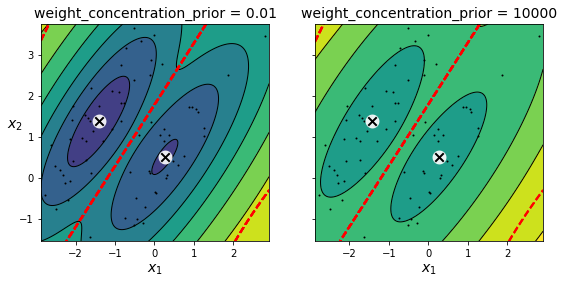

In [237]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()

In [238]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05)

In [239]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10)

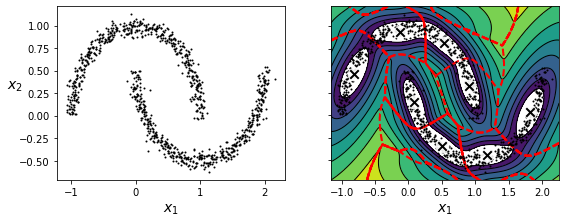

In [240]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

plt.show()

### Likelihood Function

In [241]:
from scipy.stats import norm

In [242]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

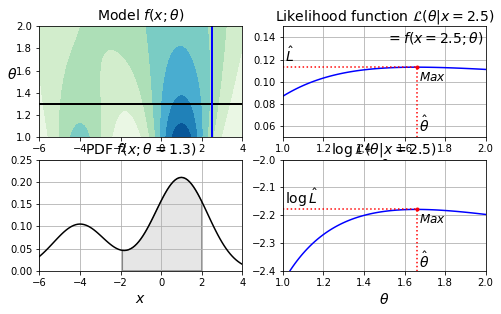

In [243]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.show()

# End of Chapter Exercises

1. How would you define clustering? Can you name a few clustering algorithms?
2. What are some of the main applications of clustering algorithms?
3. Describe two techniques to select the right number of clusters when using
   K-Means.
4. What is label propagation? Why would you implement it, and how?
5. Can you name two clustering algorithms that can scale to large datasets? And
   two that look for regions of high density?
6. Can you think of a use case where active learning would be useful? How would
   you implement it?
7. What is the difference between anomaly detection and novelty detection?
8. What is a Gaussian mixture? What tasks can you use it for?
9. Can you name two techniques to find the right number of clusters when using a
   Gaussian mixture model?
10. The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of
    faces. Each image is flattened to a 1D vector of size 4,096. 40 different people
    were photographed (10 times each), and the usual task is to train a model that
    can predict which person is represented in each picture. Load the dataset using
    the sklearn.datasets.fetch_olivetti_faces() function, then split it into a
    training set, a validation set, and a test set (note that the dataset is already scaled
    between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in
    each set. Next, cluster the images using K-Means, and ensure that you have a
    good number of clusters (using one of the techniques discussed in this chapter).
    Visualize the clusters: do you see similar faces in each cluster?
11. Continuing with the Olivetti faces dataset, train a classifier to predict which per‐
    son is represented in each picture, and evaluate it on the validation set. Next, use
    K-Means as a dimensionality reduction tool, and train a classifier on the reduced
    set. Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach? What if you append the features
    from the reduced set to the original features (again, searching for the best num‐
    ber of clusters)?
12. Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the
    algorithm, you should probably reduce the dataset’s dimensionality (e.g., use
    PCA, preserving 99% of the variance). Use the model to generate some new faces
    (using the sample() method), and visualize them (if you used PCA, you will need
    to use its inverse_transform() method). Try to modify some images (e.g.,
    rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare
    the output of the score_samples() method for normal images and for anomalies).
13. Some dimensionality reduction techniques can also be used for anomaly detec‐
    tion. For example, take the Olivetti faces dataset and reduce it with PCA, preserv‐
    ing 99% of the variance. Then compute the reconstruction error for each image.
    Next, take some of the modified images you built in the previous exercise, and
    look at their reconstruction error: notice how much larger the reconstruction
    error is. If you plot a reconstructed image, you will see why: it tries to reconstruct
    a normal face.

***1. How would you define clustering? Can you name a few clustering algorithms?***

A: The objective of clustering is to group similar instances together into groups that are representative of each other. These are known as clusters and are great for segmenting groups. Some of the algorithms for clustering are K-Means, Mini-Batch Kmeans, DBSCAN and Gaussian Mixture Models. 

***2. What are some of the main applications of clustering algorithms?***

A: Customer Segmentation, Data Analysis, Anomaly Detection (Outlier Detection) and Image Segmentation (clustering pixels in photos according to their colors). to name a few.

***3. Describe two techniques to select the right number of clusters when using
   K-Means.***

A: Two techniques that can be used to select the right number of clusters in K-Means are the following:
 1. Using the elbow graph method (inflextion point in the intertia graph)
 2. Using the silhouette_score and finding the value *k* with the highest silhouette score. The silhouette score uses the following equation: (b-a)/max(a,b) where a is the mean distance to the other instances in the same cluster and b is the mean nearest-cluster distance (mean distance to the instances of the nextr closest cluster).
 
***4. What is label propagation? Why would you implement it, and how?***

A: In KMeans clustering, if there is a sample of labeled instances in the dataset you can use KMeans for a Semi-Supervised approach. Using this, you can accurately identify instances from each cluster that are labeled from the sample and then using label propagation, give all the other instances in that cluster the same label if the clustering is done effectively. This will increase accuracy as it will give a lot of the unlabeled instances a "picture" or label in these clusters. You can then use this in something like a logistic regression classifer to see the performance on the dataset. 

***5. Can you name two clustering algorithms that can scale to large datasets? And
   two that look for regions of high density?***
   
A: K-Means should scale well with big data because the time complexity of KMeans is O(n) and the BIRCH algorithm is good for large datasets as well but it depends largely on the number of features for the dataset. As a third option, you could also use Agglomerative Clustering. Higher Density Clustering algorithm examples are Mean-Shift and DBSCAN.

***6. Can you think of a use case where active learning would be useful? How would
   you implement it?***
   
A: Active Learning is useful when a human expert is easily able to identify some of the instances in the training set so semi-supervised learning can be implemented. Ideally it would also be useful for if soft clustering is applied to the instances in clusters. So if a model is not sure of an instance or it has fairly high probabilities for several instances, this is where expertise can be applied. Once the instances are labeled, they are fed back into either the Clustering algorithm or the pipeline and performance is evaluated. This would continue until performance no longer improves or it is no longer worth the effort. 

***7. What is the difference between anomaly detection and novelty detection?***

A: Anomaly detection is the following:
- An algorithm used to check the affinity of instances in clusters. the ones with the lowest affinity is likely to be an anomaly. This is also known as outlier detection and can be used in real life applications such as fraud detection systems.

Novelty Detection is the following:
- Novelty Detection is similar to the above definition, only the dataset it trains on is clean with no outliers whatsoever. So it learns what appears to be normal strictly. 

***8. What is a Gaussian mixture? What tasks can you use it for?***

A: A Gaussian Mixture model is a probabilistic model that assumes the data points are from finite gaussian distributions that are not labelled or with unknown parameters. It can be used for Anomaly Detection from Question #7 and and finding patterns in datasets.

***9. Can you name two techniques to find the right number of clusters when using a
   Gaussian mixture model?***
   
A: You could either use BIC (Baysian information criterion) or AIC (Akaike information criterion) and plot it as a function of the number of clusters you would choose *k*. The other method could be to use the likelihood function and calculate the integral for the PDF (probability density function) to determine the probability distribution of a future outcome x. 

In [244]:
# Question 10
'''10. The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of
    faces. Each image is flattened to a 1D vector of size 4,096. 40 different people
    were photographed (10 times each), and the usual task is to train a model that
    can predict which person is represented in each picture. Load the dataset using
    the sklearn.datasets.fetch_olivetti_faces() function, then split it into a
    training set, a validation set, and a test set (note that the dataset is already scaled
    between 0 and 1). Since the dataset is quite small, you probably want to use stratified 
    sampling to ensure that there are the same number of images per person in each set. 
    Next, cluster the images using K-Means, and ensure that you have a
    good number of clusters (using one of the techniques discussed in this chapter).
    Visualize the clusters: do you see similar faces in each cluster?'''
#Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()
print(olivetti.DESCR)


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [245]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [246]:
olivetti.data

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

In [247]:
# then split it into a training set, a validation set, and a test set (note that the dataset is already scaled
# between 0 and 1). Since the dataset is quite small, you probably want to use stratified 
# sampling to ensure that there are the same number of images per person in

from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target)) # train_valid_idx is size 360, test_idx is size 40
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]


strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid)) # train_valid_idx is size 280, test_idx is size 80
X_train = X_train_valid[train_idx] #fills first 280 from X_train_valid
y_train = y_train_valid[train_idx] #fills first 280 from y_train_valid
X_valid = X_train_valid[valid_idx] #fills last 80 from X_train_valid
y_valid = y_train_valid[valid_idx] #fills last 80 from X_train_valid

In [248]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


Now we can apply what a method we learned about from our last chapter, PCA. This will help with the data dimemsionality:

In [249]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

200

In [250]:
# Next, cluster the images using K-Means, and ensure that you have a
# good number of clusters (using one of the techniques discussed in this chapter).

# do 100 clusters
from sklearn.cluster import KMeans

kmeans_per_k = []
for k in range(2,201, 2):
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k).fit(X_train_pca)
    kmeans_per_k.append(kmeans.inertia_)

k=2
k=4
k=6
k=8
k=10
k=12
k=14
k=16
k=18
k=20
k=22
k=24
k=26
k=28
k=30
k=32
k=34
k=36
k=38
k=40
k=42
k=44
k=46
k=48
k=50
k=52
k=54
k=56
k=58
k=60
k=62
k=64
k=66
k=68
k=70
k=72
k=74
k=76
k=78
k=80
k=82
k=84
k=86
k=88
k=90
k=92
k=94
k=96
k=98
k=100
k=102
k=104
k=106
k=108
k=110
k=112
k=114
k=116
k=118
k=120
k=122
k=124
k=126
k=128
k=130
k=132
k=134
k=136
k=138
k=140
k=142
k=144
k=146
k=148
k=150
k=152
k=154
k=156
k=158
k=160
k=162
k=164
k=166
k=168
k=170
k=172
k=174
k=176
k=178
k=180
k=182
k=184
k=186
k=188
k=190
k=192
k=194
k=196
k=198
k=200


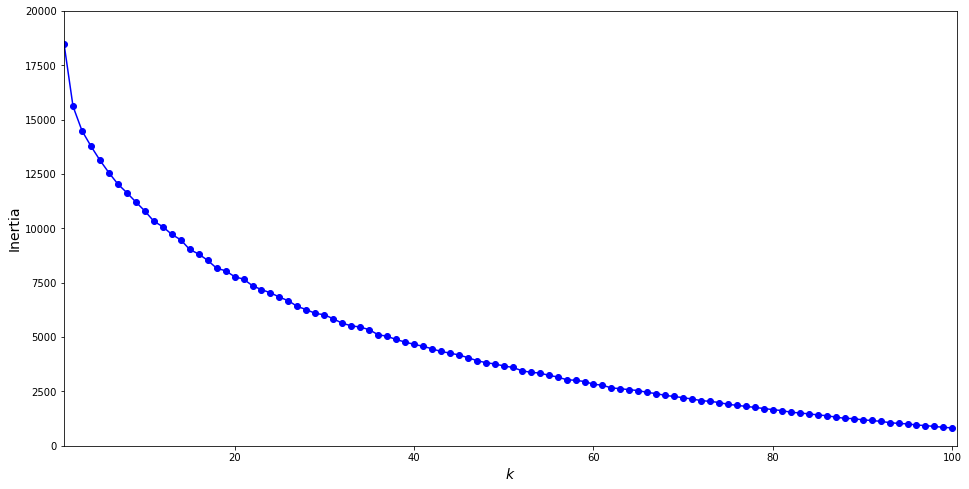

In [251]:
plt.figure(figsize=(16, 8))
plt.plot(range(1, 101), kmeans_per_k, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 100.5, 0, 20000])
plt.show()

Hard to tell what is best here. Not an immediate elbow kink. Continious decrease in inertia. Let's use the silhouette_score:

In [252]:
k_range = range(2, 201, 2)
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

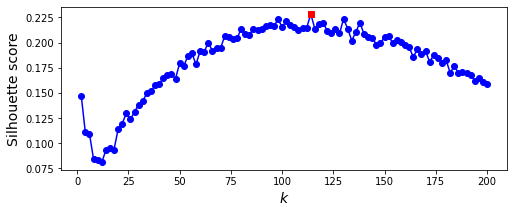

In [253]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [254]:
best_k

114

Looks like our best cluster value was at k = 114 Now let's replot our elbow curve with our best k value and the best inertia:

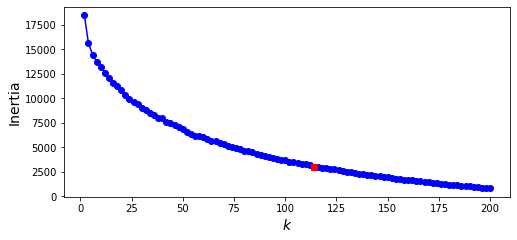

In [255]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

Now you'll note it doesn't have the lowest intertia, but it is important to note that the more clusters we have, the lower the inertia goes. This is best based off of the silhouette score

In [256]:
best_model = kmeans_per_k[best_index]

Cluster 0


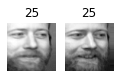

Cluster 1


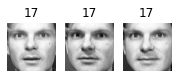

Cluster 2


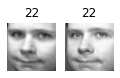

Cluster 3


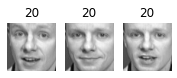

Cluster 4


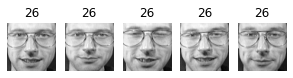

Cluster 5


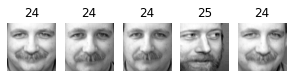

Cluster 6


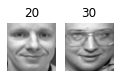

Cluster 7


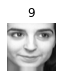

Cluster 8


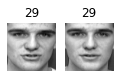

Cluster 9


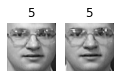

Cluster 10


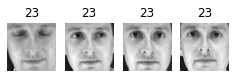

Cluster 11


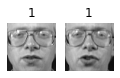

Cluster 12


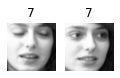

Cluster 13


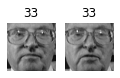

Cluster 14


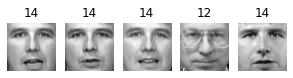

Cluster 15


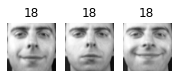

Cluster 16


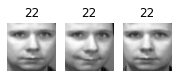

Cluster 17


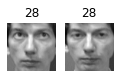

Cluster 18


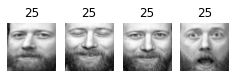

Cluster 19


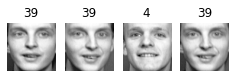

Cluster 20


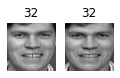

Cluster 21


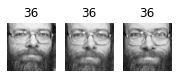

Cluster 22


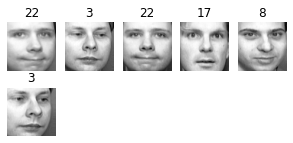

Cluster 23


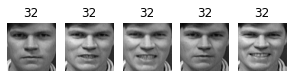

Cluster 24


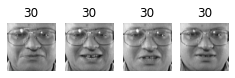

Cluster 25


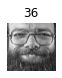

Cluster 26


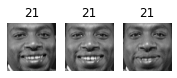

Cluster 27


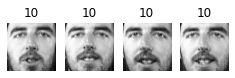

Cluster 28


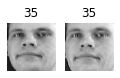

Cluster 29


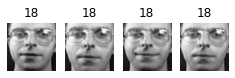

Cluster 30


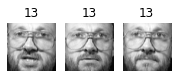

Cluster 31


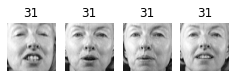

Cluster 32


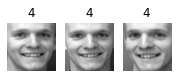

Cluster 33


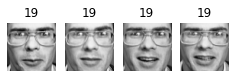

Cluster 34


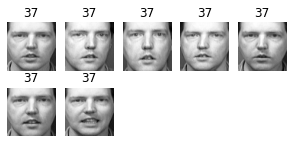

Cluster 35


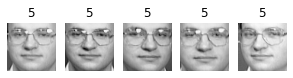

Cluster 36


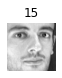

Cluster 37


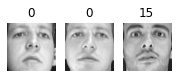

Cluster 38


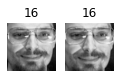

Cluster 39


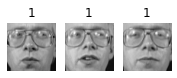

Cluster 40


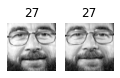

Cluster 41


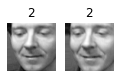

Cluster 42


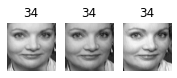

Cluster 43


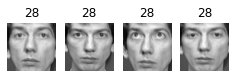

Cluster 44


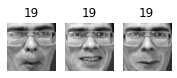

Cluster 45


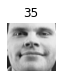

Cluster 46


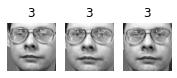

Cluster 47


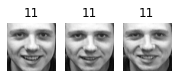

Cluster 48


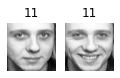

Cluster 49


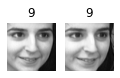

Cluster 50


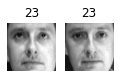

Cluster 51


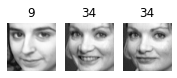

Cluster 52


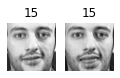

Cluster 53


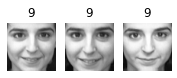

Cluster 54


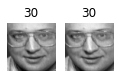

Cluster 55


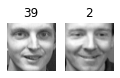

Cluster 56


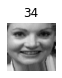

Cluster 57


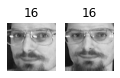

Cluster 58


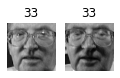

Cluster 59


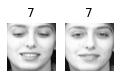

Cluster 60


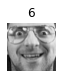

Cluster 61


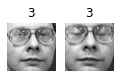

Cluster 62


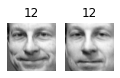

Cluster 63


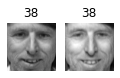

Cluster 64


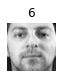

Cluster 65


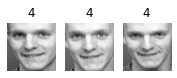

Cluster 66


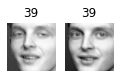

Cluster 67


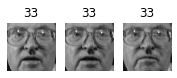

Cluster 68


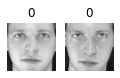

Cluster 69


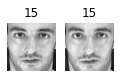

Cluster 70


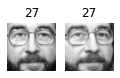

Cluster 71


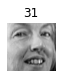

Cluster 72


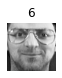

Cluster 73


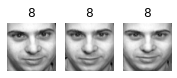

Cluster 74


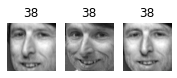

Cluster 75


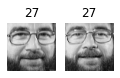

Cluster 76


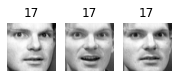

Cluster 77


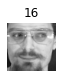

Cluster 78


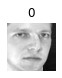

Cluster 79


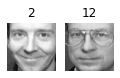

Cluster 80


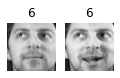

Cluster 81


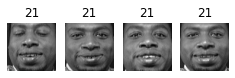

Cluster 82


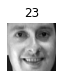

Cluster 83


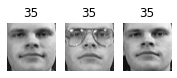

Cluster 84


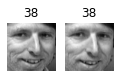

Cluster 85


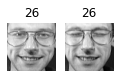

Cluster 86


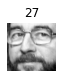

Cluster 87


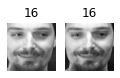

Cluster 88


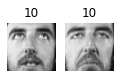

Cluster 89


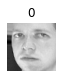

Cluster 90


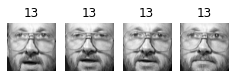

Cluster 91


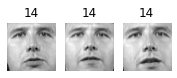

Cluster 92


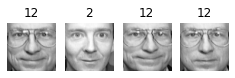

Cluster 93


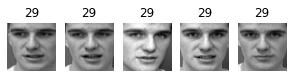

Cluster 94


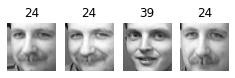

Cluster 95


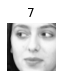

Cluster 96


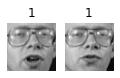

Cluster 97


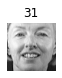

Cluster 98


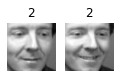

Cluster 99


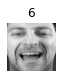

Cluster 100


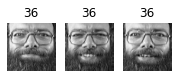

Cluster 101


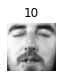

Cluster 102


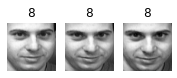

Cluster 103


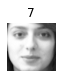

Cluster 104


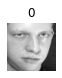

Cluster 105


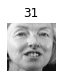

Cluster 106


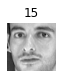

Cluster 107


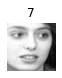

Cluster 108


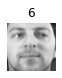

Cluster 109


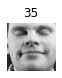

Cluster 110


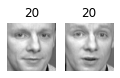

Cluster 111


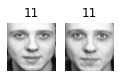

Cluster 112


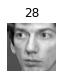

Cluster 113


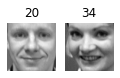

In [257]:
# Visualize the clusters: do you see similar faces in each cluster?

def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

In [260]:
# Question #11
'''11. Continuing with the Olivetti faces dataset, train a classifier to predict which per‐
    son is represented in each picture, and evaluate it on the validation set. Next, use
    K-Means as a dimensionality reduction tool, and train a classifier on the reduced
    set. Search for the number of clusters that allows the classifier to get the best performance: 
    what performance can you reach? What if you append the features
    from the reduced set to the original features (again, searching for the best num‐
    ber of clusters)?'''

#Continuing with the Olivetti faces dataset, train a classifier to predict which person 
#is represented in each picture, and evaluate it on the validation set.

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C = 5.0, solver='liblinear', max_iter=250, verbose=2)
LR.fit(X_train_pca, y_train)
LR.score(X_val_pca, y_valid)

[LibLinear]

1.0

Wow! Great Results! Let's try again now with an Support Vector Classifier and a RandomForestClassifier

In [261]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf_SVC = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_SVC.fit(X_train_pca, y_train)
clf_SVC.score(X_val_pca, y_valid)

0.9625

Also very good! Let us finish up with a randomforest.

In [263]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train_pca, y_train)
clf.score(X_val_pca, y_valid)

0.9375

Also not bad! Let's now move onto the second task in the question

In [264]:
# Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.

# Set new variables using our best model from the previous exercise
X_train_reduced = best_model.transform(X_train_pca)
X_val_reduced = best_model.transform(X_val_pca)
X_test_reduced = best_model.transform(X_test_pca)

# Train with SVM 
clf_SVC = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_SVC.fit(X_train_reduced, y_train)
clf_SVC.score(X_val_reduced, y_valid)

0.725

That is definitely not an improvement... We could use Grid Search to try and improve performance but we're using the validation set.. So no need for Cross Validation. Let's juse use a for loop and do it that way

In [269]:
# Search for the number of clusters that allows the classifier to get the best performance: 
# what performance can you reach?
from sklearn.cluster import KMeans
for n_clusters in k_range:
    clf_SVC = make_pipeline(KMeans(n_clusters=n_clusters), StandardScaler(), SVC(gamma='auto'))
    clf_SVC.fit(X_train_pca, y_train)
    print(n_clusters, clf_SVC.score(X_val_pca, y_valid))

2 0.2
4 0.425
6 0.5
8 0.475
10 0.5375
12 0.5625
14 0.55
16 0.5625
18 0.6125
20 0.6125
22 0.6
24 0.6125
26 0.6625
28 0.65
30 0.675
32 0.7
34 0.6375
36 0.6625
38 0.6875
40 0.675
42 0.6625
44 0.6625
46 0.6875
48 0.6875
50 0.675
52 0.675
54 0.7
56 0.6875
58 0.7
60 0.6875
62 0.6875
64 0.725
66 0.675
68 0.7
70 0.6875
72 0.7
74 0.6875
76 0.6875
78 0.6625
80 0.7
82 0.7
84 0.675
86 0.6875
88 0.725
90 0.725
92 0.6875
94 0.7
96 0.7125
98 0.725
100 0.725
102 0.725
104 0.7
106 0.7125
108 0.7
110 0.7125
112 0.7125
114 0.7
116 0.725
118 0.7
120 0.725
122 0.7
124 0.7125
126 0.725
128 0.6875
130 0.7125
132 0.725
134 0.7
136 0.7125
138 0.7125
140 0.7
142 0.725
144 0.7
146 0.7
148 0.7
150 0.7
152 0.7
154 0.725
156 0.7125
158 0.7125
160 0.7125
162 0.7125
164 0.7
166 0.7125
168 0.7125
170 0.725
172 0.725
174 0.7125
176 0.7125
178 0.7125
180 0.725
182 0.725
184 0.7125
186 0.7125
188 0.7125
190 0.7125
192 0.7125
194 0.7125
196 0.7125
198 0.7125
200 0.7125


Doesn't look like we're going to get above 80% accuracy here... Doesn't look like creating clusters helps improve performance for classifying these images correctly. Let's move on to the last part of this exercise:

In [274]:
# What if you append the features from the reduced set to the 
# original features (again, searching for the best number of clusters)?
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_val_extended = np.c_[X_val_pca, X_val_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

clf_SVC = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_SVC.fit(X_train_extended, y_train)
clf_SVC.score(X_val_extended, y_valid)

0.8875

Much better than what we we getting! But still not as good as our original estimates. For this scenario, clusters are not useful to directly train a classifer but helps when labeling new training instances.

In [287]:
# Question 12
"""12. Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the
    algorithm, you should probably reduce the dataset’s dimensionality (e.g., use
    PCA, preserving 99% of the variance). Use the model to generate some new faces
    (using the sample() method), and visualize them (if you used PCA, you will need
    to use its inverse_transform() method). Try to modify some images (e.g.,
    rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare
    the output of the score_samples() method for normal images and for anomalies)."""

#Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the
# algorithm, you should probably reduce the dataset’s dimensionality (e.g., use
# PCA, preserving 99% of the variance).

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40) # 40 Classes
y_pred = gm.fit_predict(X_train_pca) # already applied PCA earlier on the X_train_pca set 

In [288]:
# Use the model to generate some new faces (using the sample() method), 
# and visualize them (if you used PCA, you will need
# to use its inverse_transform() method).

new_faces_sample = 15
new_faces_reduced, y_faces = gm.sample(n_samples=new_faces_sample)
new_faces = pca.inverse_transform(new_faces_reduced)

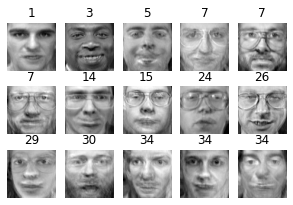

In [289]:
plot_faces(new_faces, y_faces)

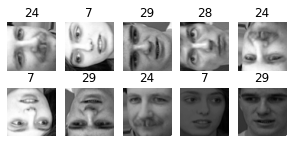

In [290]:
# Try to modify some images (e.g.,rotate, flip, darken) and 
# see if the model can detect the anomalies (i.e., compare the 
# output of the score_samples() method for normal images and for anomalies).

n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [291]:
X_bad_faces_pca = pca.transform(X_bad_faces)

gm.score_samples(X_bad_faces_pca)

array([-31728285.78644373, -37465931.40822055, -26804192.47218706,
       -27507628.86541168, -26298382.33633944, -39495878.95232257,
       -27824220.78163413, -81709729.41493304, -81877341.3054418 ,
       -99204784.61305535])

In [294]:
gm.score_samples(X_train_pca[:10])

array([1109.83303331, 1168.03442492, 1111.58775654, 1125.66938997,
       1045.12009057, 1176.61731582, 1130.98712809, 1123.60667886,
       1184.23701278, 1161.27271992])

From here, we note that the examples we created are highly unlikely in the GM Model. Above you can see as we compared to the ones we have from our training set and it gave strong negative scores for our anomalies. Great!

In [295]:
# Question #13
'''13. Some dimensionality reduction techniques can also be used for anomaly detection.
    For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% 
    of the variance. Then compute the reconstruction error for each image. Next, take 
    some of the modified images you built in the previous exercise, and look at their 
    reconstruction error: notice how much larger the reconstruction error is. If you plot 
    a reconstructed image, you will see why: it tries to reconstruct a normal face.'''
 
# For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance.

#This is already done shown below:
X_train_pca

array([[-9.8367646e-02, -2.3999164e-01,  6.1114049e-01, ...,
         7.5396813e-02, -1.4580631e-01,  6.8390027e-02],
       [-1.4377705e+00,  9.1777620e+00,  2.3542824e+00, ...,
        -1.3356404e-01, -8.7932035e-02, -2.9157561e-01],
       [ 4.2427230e+00, -1.3565396e+00, -1.9307836e+00, ...,
        -1.9850397e-01,  8.3900057e-03, -4.5567885e-02],
       ...,
       [-2.1381829e+00,  5.1302910e+00, -4.2925663e+00, ...,
        -8.1935048e-02, -6.8162559e-03,  3.9776810e-02],
       [ 4.4155788e+00, -5.8112735e-01, -1.5154910e+00, ...,
         2.7213198e-01, -8.6120375e-02, -4.5139022e-02],
       [ 2.1852450e+00, -1.8794658e+00,  4.5313840e+00, ...,
         2.2071014e-01,  4.1757795e-01,  4.7339752e-02]], dtype=float32)

In [300]:
# Then compute the reconstruction error for each image. Next, take 
# some of the modified images you built in the previous exercise, and look at their 
# reconstruction error: notice how much larger the reconstruction error is. If you plot 
# a reconstructed image, you will see why: it tries to reconstruct a normal face.

def reconstruction_errors(Pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [301]:
reconstruction_errors(pca, X_train).mean()

0.00018860075

In [302]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004667217

This should be higher overall because we warped the faces all over. We flipped them, rotated the photos and darkened them. If we were to plot the reconstruction of the faces after we transform them, it will try and reconstruct a normal face which is not the case because we screwed with the original photos. Example is shown below with our plot_faces function:

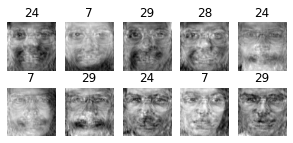

In [303]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)